# Training Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chemprop/chemprop/blob/main/examples/training_classification.ipynb)

In [1]:
import pandas as pd
from pathlib import Path

from lightning import pytorch as pl

from chemprop import data, featurizers, models, nn

In [3]:
import pandas as pd
df = pd.read_csv("../chembl.csv", sep=';')
columns = ['Molecule ChEMBL ID', 'Smiles', 'pChEMBL Value']
df = df[columns]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)


def activity(value):
  if value >= 6.5:
    return 1
  else:
    return 0



df['activity'] = df['pChEMBL Value'].apply(activity)
print(df['activity'].value_counts())


from sklearn.utils import resample

# Separate the data into active and inactive classes
active = df[df['activity'] == 1]
inactive = df[df['activity'] == 0]

# Oversample the active class to match the inactive class count
active_oversampled = resample(active,
                              replace=True,             # Allow replacement for oversampling
                              n_samples=len(inactive),  # Match the inactive class count
                              random_state=42)          # Seed for reproducibility

# Combine the oversampled active class with the inactive class
oversampled_data = pd.concat([active_oversampled, inactive])

# Shuffle the dataset
oversampled_data = oversampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(oversampled_data['activity'].value_counts())
oversampled_data.to_csv("classification.csv")

activity
1    614
0    461
Name: count, dtype: int64
activity
1    461
0    461
Name: count, dtype: int64


In [4]:
oversampled_data

,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity
0,CHEMBL3920518,CCN(CC)C(=O)c1cc2nccc(Oc3cccc(C(=O)Nc4cc(C)ccc...,6.69,1
1,CHEMBL2063319,CN1CCN(c2ccc(C(=O)Nc3cc(-c4ccc(NC(=O)OCc5ccccc...,6.70,1
2,CHEMBL3893416,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OC[C@@H]1CO...,6.00,0
3,CHEMBL518652,CC(C)c1cccc(-n2cc(-c3ccccc3NCc3ccncc3)nn2)c1,6.89,1
4,CHEMBL3628799,O=C(Nc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1)Nc1cccc(...,5.15,0
...,...,...,...,...
917,CHEMBL453737,COc1cc2c(Oc3ccc(-c4cnc(Nc5ccc(F)cc5)n(C)c4=O)c...,7.35,1
918,CHEMBL572881,CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21,8.70,1
919,CHEMBL3968192,COc1cc2c(Nc3ccc(Br)c(Cl)c3Cl)ncnc2cc1OC[C@H]1C...,6.00,0
920,CHEMBL255955,Nc1n[nH]c2nccc(-c3ccc(NC(=O)Nc4cccc(C(F)(F)F)c...,8.30,1


# Change data inputs here

In [163]:

input_path =  "classification.csv" # path to your data .csv file
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'Smiles' # name of the column containing SMILES strings
target_columns = ['activity'] # classification of activity (either 0 or 1)

## Load data

In [164]:
df_input = pd.read_csv(input_path)
df_input

,,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity
0,0,CHEMBL3920518,CCN(CC)C(=O)c1cc2nccc(Oc3cccc(C(=O)Nc4cc(C)ccc...,6.69,1
1,1,CHEMBL2063319,CN1CCN(c2ccc(C(=O)Nc3cc(-c4ccc(NC(=O)OCc5ccccc...,6.70,1
2,2,CHEMBL3893416,COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OC[C@@H]1CO...,6.00,0
3,3,CHEMBL518652,CC(C)c1cccc(-n2cc(-c3ccccc3NCc3ccncc3)nn2)c1,6.89,1
4,4,CHEMBL3628799,O=C(Nc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1)Nc1cccc(...,5.15,0
...,...,...,...,...,...
917,917,CHEMBL453737,COc1cc2c(Oc3ccc(-c4cnc(Nc5ccc(F)cc5)n(C)c4=O)c...,7.35,1
918,918,CHEMBL572881,CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21,8.70,1
919,919,CHEMBL3968192,COc1cc2c(Nc3ccc(Br)c(Cl)c3Cl)ncnc2cc1OC[C@H]1C...,6.00,0
920,920,CHEMBL255955,Nc1n[nH]c2nccc(-c3ccc(NC(=O)Nc4cccc(C(F)(F)F)c...,8.30,1


## Get SMILES and targets

In [165]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [166]:
# Take a look at the first 5 SMILES strings and target columns
smis[:5], ys[:5]

(array(['CCN(CC)C(=O)c1cc2nccc(Oc3cccc(C(=O)Nc4cc(C)ccc4F)c3)c2s1',
        'CN1CCN(c2ccc(C(=O)Nc3cc(-c4ccc(NC(=O)OCc5ccccc5)cc4)n[nH]3)cc2)CC1',
        'COc1cc2c(Nc3ccc(Cl)c(Cl)c3)ncnc2cc1OC[C@@H]1CO[C@H]2[C@@H]1OC[C@@H]2OC',
        'CC(C)c1cccc(-n2cc(-c3ccccc3NCc3ccncc3)nn2)c1',
        'O=C(Nc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1)Nc1cccc(Br)c1'],
       dtype=object),
 array([[1],
        [1],
        [0],
        [1],
        [0]]))

## Get molecule datapoints

In [167]:
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

## Perform data splitting for training, validation, and testing

In [168]:
# available split types
list(data.SplitType.keys())

['SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

In [169]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.70, 0.15, 0.15), seed=46) #42, 43, 44, 45
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

The return type of make_split_indices has changed in v2.1 - see help(make_split_indices)


In [170]:
train_indices = train_indices[0]
test_indices =  test_indices[0]
val_indices = val_indices[0]
train = df_input.iloc[train_indices]
test = df_input.iloc[test_indices]
val = df_input.iloc[val_indices]




In [171]:
train.to_csv("train.csv")
test.to_csv("test.csv")
val.to_csv("val.csv")

## Get MoleculeDataset

In [172]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer)
val_dset = data.MoleculeDataset(val_data[0], featurizer)
test_dset = data.MoleculeDataset(test_data[0], featurizer)

## Get DataLoader

In [173]:
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

# Change Message-Passing Neural Network (MPNN) inputs here

## Message Passing
A `Message passing` constructs molecular graphs using message passing to learn node-level hidden representations.

Options are `mp = nn.BondMessagePassing()` or `mp = nn.AtomMessagePassing()`

In [174]:
mp = nn.BondMessagePassing()

## Aggregation
An `Aggregation` is responsible for constructing a graph-level representation from the set of node-level representations after message passing.

Available options can be found in ` nn.agg.AggregationRegistry`, including
- `agg = nn.MeanAggregation()`
- `agg = nn.SumAggregation()`
- `agg = nn.NormAggregation()`

In [175]:
print(nn.agg.AggregationRegistry)

ClassRegistry {
    'mean': <class 'chemprop.nn.agg.MeanAggregation'>,
    'sum': <class 'chemprop.nn.agg.SumAggregation'>,
    'norm': <class 'chemprop.nn.agg.NormAggregation'>
}


In [180]:
agg = nn.MeanAggregation()

## Feed-Forward Network (FFN)

A `FFN` takes the aggregated representations and make target predictions.

Available options can be found in `nn.PredictorRegistry`.

For regression:
- `ffn = nn.RegressionFFN()`
- `ffn = nn.MveFFN()`
- `ffn = nn.EvidentialFFN()`

For classification:
- `ffn = nn.BinaryClassificationFFN()`
- `ffn = nn.BinaryDirichletFFN()`
- `ffn = nn.MulticlassClassificationFFN()`
- `ffn = nn.MulticlassDirichletFFN()`

For spectral:
- `ffn = nn.SpectralFFN()` # will be available in future version

In [181]:
print(nn.PredictorRegistry)

ClassRegistry {
    'regression': <class 'chemprop.nn.predictors.RegressionFFN'>,
    'regression-mve': <class 'chemprop.nn.predictors.MveFFN'>,
    'regression-evidential': <class 'chemprop.nn.predictors.EvidentialFFN'>,
    'regression-quantile': <class 'chemprop.nn.predictors.QuantileFFN'>,
    'classification': <class 'chemprop.nn.predictors.BinaryClassificationFFN'>,
    'classification-dirichlet': <class 'chemprop.nn.predictors.BinaryDirichletFFN'>,
    'multiclass': <class 'chemprop.nn.predictors.MulticlassClassificationFFN'>,
    'multiclass-dirichlet': <class 'chemprop.nn.predictors.MulticlassDirichletFFN'>,
    'spectral': <class 'chemprop.nn.predictors.SpectralFFN'>
}


In [182]:
ffn = nn.BinaryClassificationFFN(n_tasks = len(target_columns))

## Batch Norm
A `Batch Norm` normalizes the outputs of the aggregation by re-centering and re-scaling.

Whether to use batch norm

In [183]:
batch_norm = False

## Metrics
`Metrics` are the ways to evaluate the performance of model predictions.

Available options can be found in `metrics.MetricRegistry`, including

In [184]:
print(nn.metrics.MetricRegistry)

ClassRegistry {
    'mse': <class 'chemprop.nn.metrics.MSE'>,
    'mae': <class 'chemprop.nn.metrics.MAE'>,
    'rmse': <class 'chemprop.nn.metrics.RMSE'>,
    'bounded-mse': <class 'chemprop.nn.metrics.BoundedMSE'>,
    'bounded-mae': <class 'chemprop.nn.metrics.BoundedMAE'>,
    'bounded-rmse': <class 'chemprop.nn.metrics.BoundedRMSE'>,
    'r2': <class 'chemprop.nn.metrics.R2Score'>,
    'binary-mcc': <class 'chemprop.nn.metrics.BinaryMCCMetric'>,
    'multiclass-mcc': <class 'chemprop.nn.metrics.MulticlassMCCMetric'>,
    'roc': <class 'chemprop.nn.metrics.BinaryAUROC'>,
    'prc': <class 'chemprop.nn.metrics.BinaryAUPRC'>,
    'accuracy': <class 'chemprop.nn.metrics.BinaryAccuracy'>,
    'f1': <class 'chemprop.nn.metrics.BinaryF1Score'>
}


In [185]:
# AUROC used by default
metric_list = [nn.metrics.BinaryAccuracy(), nn.metrics.BinaryF1Score(), nn.metrics.BinaryAUPRC(), nn.metrics.BinaryMCCMetric()] 

## Constructs MPNN

In [186]:
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)

mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): BinaryClassificationFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): BCELoss(task_weights=[[1.0]])
    (output_transform): Identity()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): BinaryAccuracy()
    (1): BinaryF1Score()
    (2): BinaryAUPRC()
    (3): BinaryMCCMetric(task_weights=[[1.0]])
  

# Set up trainer

In [187]:
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="mps",
    devices=1,
    max_epochs=50, # number of epochs to train for

)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Start training

In [188]:
trainer.fit(mpnn, train_loader, val_loader) # Use `ckpt_path` to load a checkpoint if you want to resume training from a saved checkpoint.

/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/sefunmibodun/Documents/optimist/vegfr1/mlmodel/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

  | Name            | Type                    | Params | Mode 
--------------------------------------------------------------------
0 | message_passing | BondMessagePassing      | 227 K  | train
1 | agg             | MeanAggregation         | 0      | train
2 | bn              | Identity                | 0      | train
3 | predictor       | BinaryClassificat

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 11/11 [00:20<00:00,  0.53it/s, train_loss_step=0.590, val_loss=0.615, train_loss_epoch=0.446]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 11/11 [00:20<00:00,  0.53it/s, train_loss_step=0.590, val_loss=0.615, train_loss_epoch=0.446]


# Test results

In [189]:
results = trainer.test(mpnn, test_loader)

/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:16<00:00,  0.18it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.7338129281997681     │
│      test/binary-mcc      │    0.3552231192588806     │
│          test/f1          │    0.7482993006706238     │
│         test/prc          │    0.8417859077453613     │
└───────────────────────────┴───────────────────────────┘

In [62]:
results1 = results[0]  # results is a list of dictionaries, we take the first one
results1

{'test/accuracy': 0.7625899314880371,
 'test/f1': 0.7724137902259827,
 'test/prc': 0.7921566963195801,
 'test/binary-mcc': 0.38502055406570435}

In [89]:
results2 = results[0]
results2

{'test/accuracy': 0.7050359845161438,
 'test/f1': 0.6917293071746826,
 'test/prc': 0.7332098484039307,
 'test/binary-mcc': 0.311336874961853}

In [111]:
results3 = results[0]
results3

{'test/accuracy': 0.769784152507782,
 'test/f1': 0.7575757503509521,
 'test/prc': 0.8319801688194275,
 'test/binary-mcc': 0.3575444221496582}

In [162]:
results4 = results[0]
results4

{'test/accuracy': 0.6618704795837402,
 'test/f1': 0.6666666865348816,
 'test/prc': 0.784997820854187,
 'test/binary-mcc': 0.2641364336013794}

In [190]:
results5 = results[0]
results5

{'test/accuracy': 0.7338129281997681,
 'test/f1': 0.7482993006706238,
 'test/prc': 0.8417859077453613,
 'test/binary-mcc': 0.3552231192588806}

In [33]:
trainer.test(mpnn, val_loader)

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.7637795209884644     │
│      test/binary-mcc      │    0.46242856979370117    │
│          test/f1          │    0.7727272510528564     │
│         test/prc          │    0.9077812433242798     │
└───────────────────────────┴───────────────────────────┘

[{'test/accuracy': 0.7637795209884644,
  'test/f1': 0.7727272510528564,
  'test/prc': 0.9077812433242798,
  'test/binary-mcc': 0.46242856979370117}]

In [34]:
trainer.test(mpnn, train_loader)

/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.8330522775650024     │
│      test/binary-mcc      │    0.5473436713218689     │
│          test/f1          │     0.842607319355011     │
│         test/prc          │    0.9189339876174927     │
└───────────────────────────┴───────────────────────────┘

[{'test/accuracy': 0.8330522775650024,
  'test/f1': 0.842607319355011,
  'test/prc': 0.9189339876174927,
  'test/binary-mcc': 0.5473436713218689}]

# External dataset


In [65]:
df_external = pd.read_csv('../10000_sampled_covalent.csv')
df_external

,SMILES,NLL
0,C=CC(=O)N1CC(COc2ccccc2F)CC1C(=O)NC(Cc1ccccc1)...,10.79
1,C=CC(=O)N1CC(COc2ccc(F)cc2F)CC1C(=O)NC1CCCCC1C,10.36
2,C=CC(=O)N1CC(n2ccnc2C(C)C)CCC1C,3.33
3,C=CC(=O)N1CC2CCc3cnc4ccccc4c3N2CC1C,3.52
4,C=CC(=O)N1CC(n2ccnc2CC)CC1C(=O)NC(C)CC,9.20
...,...,...
3598,C=CC(=O)N1CC2CN(C(=O)c3cncc(N)c3)C2C1,11.03
3599,C=CC(=O)N1CCC(n2cccn2)CC1C(=O)NC(C)C,14.66
3600,C=CC(=O)N1CC(c2c(C)nc3ccccc3c2C)CC1CN1CCCC1C,11.67
3601,C=CC(=O)N1CCC(Nc2ccc(CCC)nn2)C1,13.83


In [66]:
smis = df_external['SMILES']
smis

0       C=CC(=O)N1CC(COc2ccccc2F)CC1C(=O)NC(Cc1ccccc1)...
1          C=CC(=O)N1CC(COc2ccc(F)cc2F)CC1C(=O)NC1CCCCC1C
2                         C=CC(=O)N1CC(n2ccnc2C(C)C)CCC1C
3                     C=CC(=O)N1CC2CCc3cnc4ccccc4c3N2CC1C
4                  C=CC(=O)N1CC(n2ccnc2CC)CC1C(=O)NC(C)CC
                              ...                        
3598                C=CC(=O)N1CC2CN(C(=O)c3cncc(N)c3)C2C1
3599                 C=CC(=O)N1CCC(n2cccn2)CC1C(=O)NC(C)C
3600         C=CC(=O)N1CC(c2c(C)nc3ccccc3c2C)CC1CN1CCCC1C
3601                      C=CC(=O)N1CCC(Nc2ccc(CCC)nn2)C1
3602             C=CC(=O)N1CC(n2ccnc2CC)CC1CC(=O)N1CCCC1C
Name: SMILES, Length: 3603, dtype: object

In [67]:
external_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]

In [69]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
external_dset = data.MoleculeDataset(external_data, featurizer=featurizer)
external_loader = data.build_dataloader(external_dset, shuffle=False)

In [70]:
import pandas as pd
import numpy as np
import torch

In [71]:
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="mps",
        devices=1
    )
    #save model

    external_preds = trainer.predict(mpnn, external_loader)

    

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


In [72]:
external_preds = np.concatenate(external_preds, axis=0)
df_external['pred'] = external_preds
df_external

,SMILES,NLL,pred
0,C=CC(=O)N1CC(COc2ccccc2F)CC1C(=O)NC(Cc1ccccc1)...,10.79,0.008830
1,C=CC(=O)N1CC(COc2ccc(F)cc2F)CC1C(=O)NC1CCCCC1C,10.36,0.152806
2,C=CC(=O)N1CC(n2ccnc2C(C)C)CCC1C,3.33,0.384502
3,C=CC(=O)N1CC2CCc3cnc4ccccc4c3N2CC1C,3.52,0.142708
4,C=CC(=O)N1CC(n2ccnc2CC)CC1C(=O)NC(C)CC,9.20,0.332456
...,...,...,...
3598,C=CC(=O)N1CC2CN(C(=O)c3cncc(N)c3)C2C1,11.03,0.105997
3599,C=CC(=O)N1CCC(n2cccn2)CC1C(=O)NC(C)C,14.66,0.041166
3600,C=CC(=O)N1CC(c2c(C)nc3ccccc3c2C)CC1CN1CCCC1C,11.67,0.350812
3601,C=CC(=O)N1CCC(Nc2ccc(CCC)nn2)C1,13.83,0.032862


In [73]:
def activity(value):
  if value >= 0.5:
    return 1
  else:
    return 0

In [74]:
df_external['value'] = df_external['pred'].apply(activity)

In [75]:
df_external

,SMILES,NLL,pred,value
0,C=CC(=O)N1CC(COc2ccccc2F)CC1C(=O)NC(Cc1ccccc1)...,10.79,0.008830,0
1,C=CC(=O)N1CC(COc2ccc(F)cc2F)CC1C(=O)NC1CCCCC1C,10.36,0.152806,0
2,C=CC(=O)N1CC(n2ccnc2C(C)C)CCC1C,3.33,0.384502,0
3,C=CC(=O)N1CC2CCc3cnc4ccccc4c3N2CC1C,3.52,0.142708,0
4,C=CC(=O)N1CC(n2ccnc2CC)CC1C(=O)NC(C)CC,9.20,0.332456,0
...,...,...,...,...
3598,C=CC(=O)N1CC2CN(C(=O)c3cncc(N)c3)C2C1,11.03,0.105997,0
3599,C=CC(=O)N1CCC(n2cccn2)CC1C(=O)NC(C)C,14.66,0.041166,0
3600,C=CC(=O)N1CC(c2c(C)nc3ccccc3c2C)CC1CN1CCCC1C,11.67,0.350812,0
3601,C=CC(=O)N1CCC(Nc2ccc(CCC)nn2)C1,13.83,0.032862,0


In [76]:
df_external['value'].value_counts()

value
0    2836
1     767
Name: count, dtype: int64

In [77]:
df_to_dock = df_external[df_external['value'] == 1]

In [78]:
df_to_dock.reset_index(drop= True, inplace=True)

In [79]:
df_to_dock

,SMILES,NLL,pred,value
0,C=CC(=O)N1CC2CN(C(=O)c3c(C)cc(C)c(C)c3C)CC2C1,4.45,0.708101,1
1,C=CC(=O)N1CC(C)(O)c2cc(C#N)ccc21,7.06,0.994581,1
2,C=CC(=O)N1CC(n2nc(C)c(C)c2CC)CC1C,7.53,0.707353,1
3,C=CC(=O)N1CC2CN(C(=O)c3cc4nc(CC)[nH]c4c(F)c3F)...,8.66,0.622271,1
4,C=CC(=O)N1CCC(C)(N2CCc3cc(C#N)c(F)cc32)C1,3.49,0.984035,1
...,...,...,...,...
762,C=CC(=O)N1CCC2C=C(C#N)C3=C(C=C4C(=O)N(C=C4C1)C...,17.70,0.925210,1
763,C=CC(=O)N1CC(C)(O)C1c1cccnc1O,15.64,0.680693,1
764,C=CC(=O)N1CC2CN(C(=O)c3c(C)cc(C)[nH]c3=O)CC2C1,9.89,0.593766,1
765,C=CC(=O)N1CC(CC#N)(n2cc(C(=C)C)c(C(C)C)c2C#N)C1,14.64,0.998667,1


In [80]:
df_to_dock.to_csv('filtered_by_ML_upNext_PAINS.csv', index=False)

# visualize results

## train

In [48]:
train

,Unnamed: 0,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity
4029,4029,CHEMBL3414876,Cc1ccc(S(=O)(=O)O)cc1.O=C1Cc2cc(Cc3ccc(-c4ccnc...,6.30,0
6939,6939,CHEMBL3310881,O=C1c2ccccc2S[C@@H]2[C@@H](O)[C@@H](O)[C@H](O)...,4.71,0
6505,6505,CHEMBL45578,CCOC(=O)C(=O)CC(=O)/C=C/c1cccn1Cc1ccc(F)cc1,5.04,0
2645,2645,CHEMBL4848008,Cc1cc(/C=C/C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc2...,7.09,1
5532,5532,CHEMBL5418212,Cc1cc(/C=C/C#N)cc(C)c1Cc1nc(NC2CCN(Cc3ccc(C(N)...,6.92,1
...,...,...,...,...,...
2835,2835,CHEMBL257172,CS(=O)(=O)c1ccc(NC(=O)COc2ccc(Cl)c(Oc3cc(Cl)cc...,9.00,1
3231,3231,CHEMBL123639,CCc1cc(NCc2ccc3ccccc3n2)c(O)nc1C,6.28,0
6773,6773,CHEMBL2206505,O=C(CSc1nncnc1-c1ccccc1Cl)Nc1ccccc1[N+](=O)[O-],5.19,0
7582,7582,CHEMBL34542,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(N(C)S(C)(=O)=...,5.25,0


In [49]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

def plot_classification_metrics(y_true, y_pred_prob):
    # Calculate predicted labels based on probability threshold
    y_pred = (y_pred_prob >= 0.5).astype(int)

    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Confusion matrix for specificity calculation
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # Calculate specificity

    # Print classification metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Specificity: {specificity:.2f}")

    # Compute ROC curve and ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Confusion Matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], colorbar=False)
    axs[0].set_title('Confusion Matrix')

    # ROC Curve plot
    axs[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    axs[1].set_title('Receiver Operating Characteristic')
    axs[1].legend(loc="lower right")  # Legend in lower-right corner

    plt.tight_layout()
    plt.show()

    return

In [50]:
train  = pd.read_csv('train.csv')
smis = train['Smiles']
external_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
external_dset = data.MoleculeDataset(external_data, featurizer=featurizer)
external_loader = data.build_dataloader(external_dset, shuffle=False)
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="mps",
        devices=1
    )
    external_preds = trainer.predict(mpnn, external_loader)

external_preds = np.concatenate(external_preds, axis=0)
train['pred'] = external_preds
train


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 95/95 [00:19<00:00,  4.98it/s]


,Unnamed: 0.1,Unnamed: 0,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity,pred
0,4029,4029,CHEMBL3414876,Cc1ccc(S(=O)(=O)O)cc1.O=C1Cc2cc(Cc3ccc(-c4ccnc...,6.30,0,3.597477e-03
1,6939,6939,CHEMBL3310881,O=C1c2ccccc2S[C@@H]2[C@@H](O)[C@@H](O)[C@H](O)...,4.71,0,4.607749e-07
2,6505,6505,CHEMBL45578,CCOC(=O)C(=O)CC(=O)/C=C/c1cccn1Cc1ccc(F)cc1,5.04,0,2.795389e-06
3,2645,2645,CHEMBL4848008,Cc1cc(/C=C/C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc2...,7.09,1,9.968113e-01
4,5532,5532,CHEMBL5418212,Cc1cc(/C=C/C#N)cc(C)c1Cc1nc(NC2CCN(Cc3ccc(C(N)...,6.92,1,9.740845e-01
...,...,...,...,...,...,...,...
6037,2835,2835,CHEMBL257172,CS(=O)(=O)c1ccc(NC(=O)COc2ccc(Cl)c(Oc3cc(Cl)cc...,9.00,1,9.951970e-01
6038,3231,3231,CHEMBL123639,CCc1cc(NCc2ccc3ccccc3n2)c(O)nc1C,6.28,0,1.901191e-02
6039,6773,6773,CHEMBL2206505,O=C(CSc1nncnc1-c1ccccc1Cl)Nc1ccccc1[N+](=O)[O-],5.19,0,2.136800e-02
6040,7582,7582,CHEMBL34542,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(N(C)S(C)(=O)=...,5.25,0,1.527794e-01


Accuracy: 0.89
Precision: 0.89
Recall: 0.90
F1 Score: 0.89
Specificity: 0.88


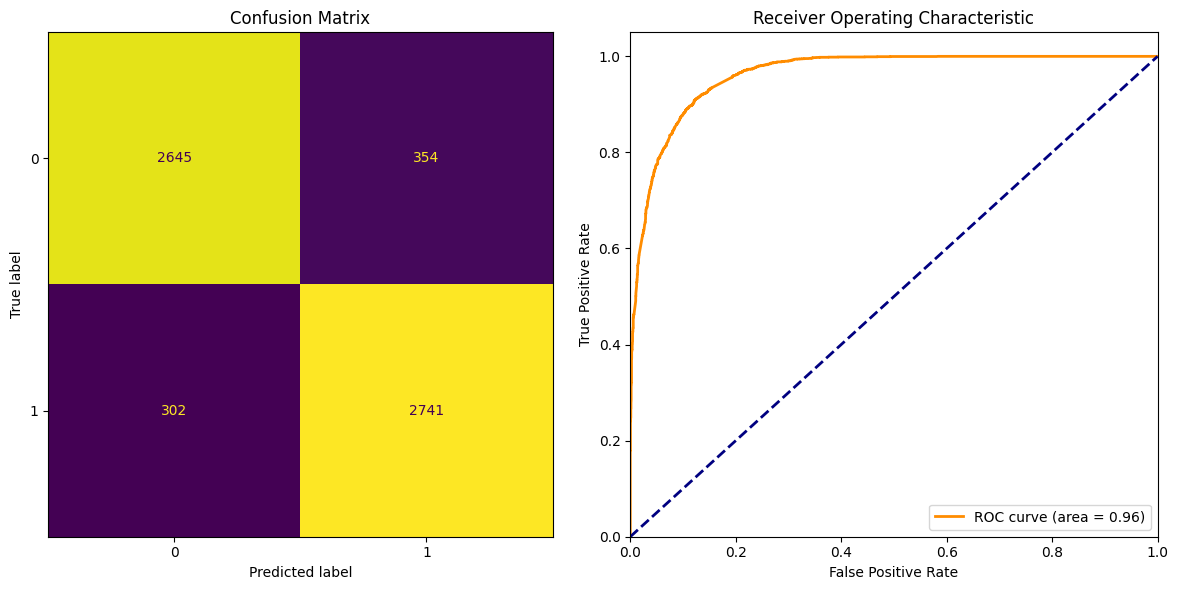

In [51]:
plot_classification_metrics(train['activity'], train['pred'])

## test

In [52]:
test  = pd.read_csv('test.csv')
smis = test['Smiles']
external_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
external_dset = data.MoleculeDataset(external_data, featurizer=featurizer)
external_loader = data.build_dataloader(external_dset, shuffle=False)
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="mps",
        devices=1
    )
    external_preds = trainer.predict(mpnn, external_loader)

external_preds = np.concatenate(external_preds, axis=0)
test['pred'] = external_preds
test


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 21/21 [00:02<00:00,  9.78it/s]


,Unnamed: 0.1,Unnamed: 0,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity,pred
0,3344,3344,CHEMBL4288759,O=c1nc(Nc2ccc(-c3cnc4ccccc4c3)cc2)c2cccnc2n1O,6.16,0,0.694322
1,4210,4210,CHEMBL519162,CC(C)=CN1[C@@H](C)Cn2c(=S)[nH]c3cccc(c32)[C@@H]1C,7.38,1,0.716331
2,5912,5912,CHEMBL4854307,Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)nc2c1CSCC2,7.39,1,0.998590
3,1594,1594,CHEMBL198201,COC(=O)CCC/C=C(\c1cccc(C#N)c1)c1cc(C)c2onc(OC)...,5.24,0,0.043222
4,957,957,CHEMBL436376,CCOc1ccc(F)c(CC/N=C(\S)Nc2ccc(Br)cn2)c1C#N,8.70,1,0.852315
...,...,...,...,...,...,...,...
1291,7891,7891,CHEMBL1169811,Cc1cc(C#N)cc(C)c1Oc1ccnc(NC2CCN(Cc3ccc(S(C)(=O...,7.47,1,0.922513
1292,4859,4859,CHEMBL319224,N#Cc1ccc(F)c(CC/N=C(\S)Nc2ccc(Cl)cn2)c1F,7.05,1,0.776449
1293,3264,3264,CHEMBL308222,C=C(C)CN1Cc2cc(Cl)cc3[nH]c(=S)n(c23)C(C)C1,6.17,0,0.056750
1294,2732,2732,CHEMBL176107,CCc1c(C)[nH]c(=O)c(N(C)CCCCCO)c1Cc1cc(C)cc(C)c1,8.40,1,0.989070


Accuracy: 0.82
Precision: 0.79
Recall: 0.86
F1 Score: 0.82
Specificity: 0.79


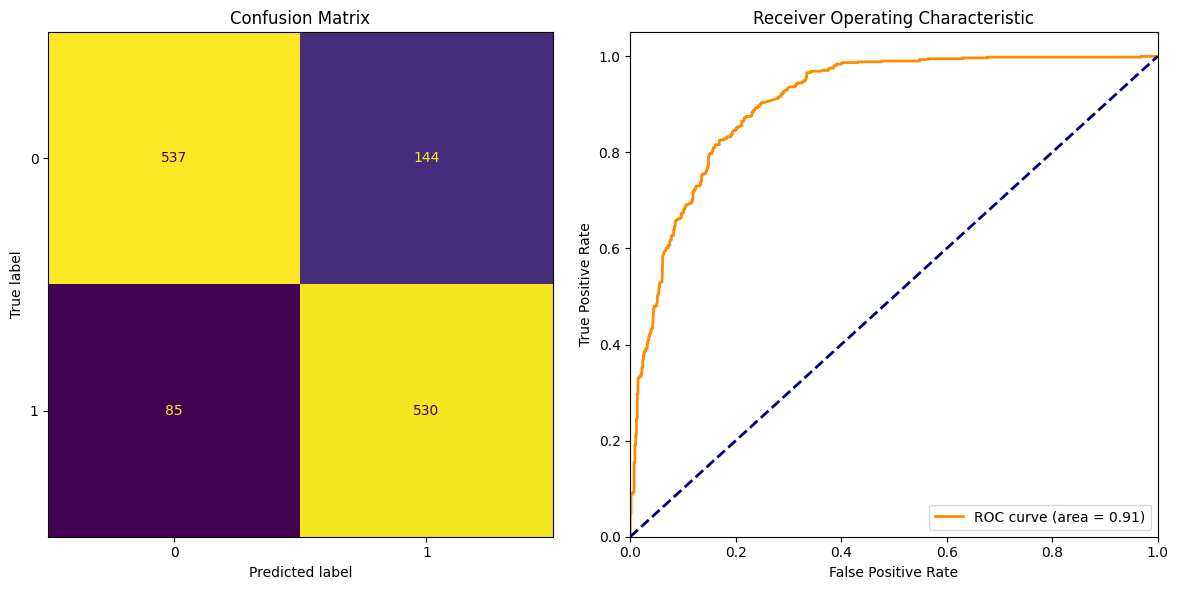

In [53]:
plot_classification_metrics(test['activity'], test['pred'])

## validation

In [54]:
val  = pd.read_csv('val.csv')
smis = val['Smiles']
external_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
external_dset = data.MoleculeDataset(external_data, featurizer=featurizer)
external_loader = data.build_dataloader(external_dset, shuffle=False)
with torch.inference_mode():
    trainer = pl.Trainer(
        logger=None,
        enable_progress_bar=True,
        accelerator="mps",
        devices=1
    )
    external_preds = trainer.predict(mpnn, external_loader)

external_preds = np.concatenate(external_preds, axis=0)
val['pred'] = external_preds
val


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/core/saving.py:363: Skipping 'metrics' parameter because it is not possible to safely dump to YAML.
/Users/sefunmibodun/anaconda3/envs/chemprop/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 21/21 [00:02<00:00,  7.53it/s]


,Unnamed: 0.1,Unnamed: 0,Molecule ChEMBL ID,Smiles,pChEMBL Value,activity,pred
0,6865,6865,CHEMBL4167795,Cc1cc(-c2cccc(F)c2)cc(C)c1Nc1ccnc(Nc2ccc(C#N)c...,7.92,1,0.993323
1,1354,1354,CHEMBL5197260,COc1ccc(-c2cc(C)c(Oc3cc(N)nc(Nc4ccc(C#N)cc4)n3...,7.27,1,0.993140
2,3127,3127,CHEMBL4294297,Cc1cc(C#N)cc(C)c1Oc1nc(Nc2ccc(C#N)cc2)ncc1SCC(...,7.89,1,0.991674
3,5089,5089,CHEMBL5402427,Cc1cc(-c2ccc(C#N)cc2)cc(C)c1Oc1nc(Nc2ccc(C#N)c...,6.48,0,0.184364
4,6652,6652,CHEMBL5206836,Cn1c(Cn2ccc(C(F)(F)F)c(Oc3ccc(-c4ccc(C#N)cc4)c...,5.17,0,0.014879
...,...,...,...,...,...,...,...
1289,2061,2061,CHEMBL469358,Cc1cc(C)cc(S(=O)(=O)c2c(C(=O)NC(C)CC(N)=O)[nH]...,6.54,1,0.176823
1290,6779,6779,CHEMBL122343,CN(c1ncccc1NC1CC1)C1CCN(C(=O)c2cc3cc(NS(C)(=O)...,7.05,1,0.375671
1291,6114,6114,CHEMBL89674,O=C(CCCCC(=O)Nc1ccc(C(F)(F)F)cc1C(=O)O)Nc1ccc(...,4.92,0,0.000494
1292,3940,3940,CHEMBL268871,CCc1cc(NCc2nc3c(Cl)ccc(Cl)c3o2)c(O)nc1C,5.11,0,0.676856


Accuracy: 0.83
Precision: 0.83
Recall: 0.84
F1 Score: 0.83
Specificity: 0.82


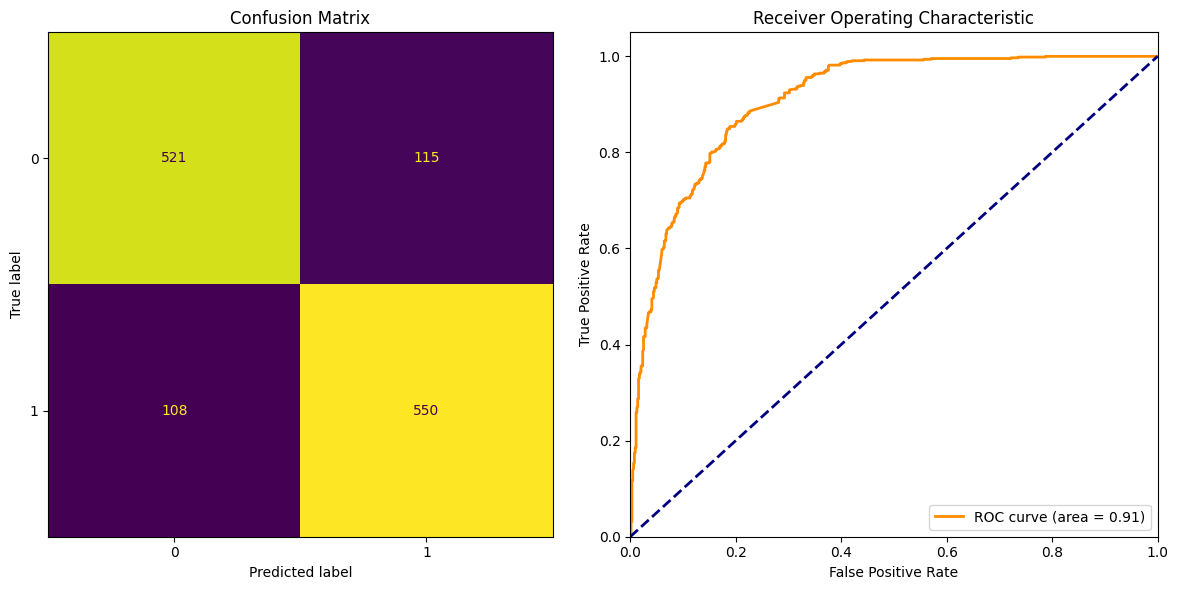

In [55]:
plot_classification_metrics(val['activity'], val['pred'])